In [1]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from google.colab import drive
import pandas as pd
from scipy import signal

In [2]:
# ドライブのマウント
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ローパスフィルタを適用する関数
def apply_lowpass_filter(data, samplerate=200, fp=30, fs=50, gpass=1, gstop=40):
    """
    ローパスフィルタをデータに適用する関数

    :param data: フィルタリング対象のデータ (Pandas DataFrame)
    :param samplerate: サンプリングレート (Hz)
    :param fp: 通過域端周波数 (Hz)
    :param fs: 阻止域端周波数 (Hz)
    :param gpass: 通過域最大損失量 (dB)
    :param gstop: 阻止域最小減衰量 (dB)
    :return: フィルタリングされたデータ (Pandas DataFrame)
    """
    fn = samplerate / 2  # ナイキスト周波数
    Wp = fp / fn  # 正規化通過域端周波数
    Ws = fs / fn  # 正規化阻止域端周波数

    # バターワースフィルタの設計
    N, Wn = signal.buttord(Wp, Ws, gpass, gstop)
    b, a = signal.butter(N, Wn, 'low')

    # フィルタの適用
    filtered_data = data.copy()
    for col in filtered_data.columns:
        filtered_data[col] = signal.filtfilt(b, a, filtered_data[col])

    return filtered_data


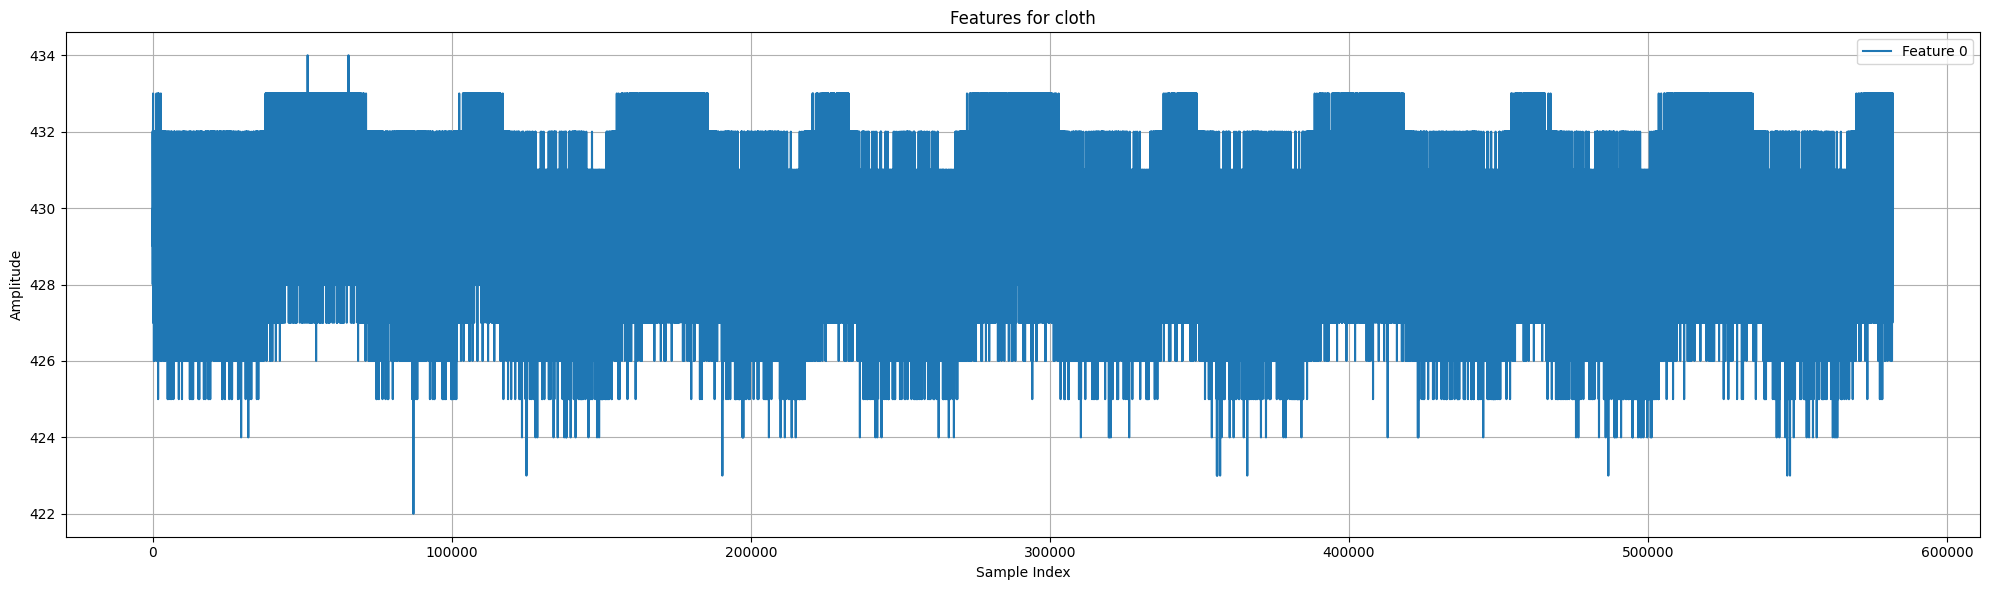

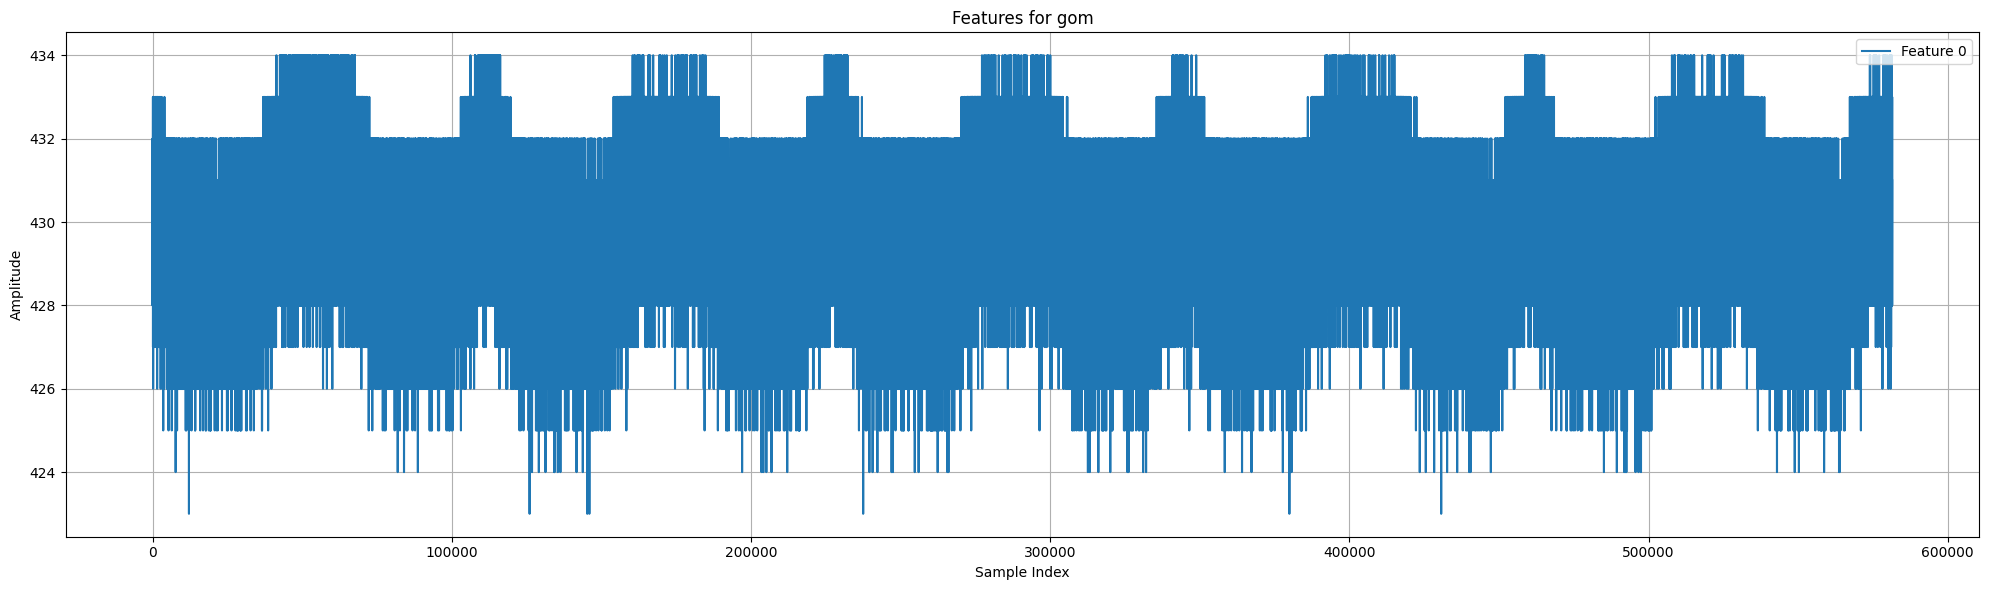

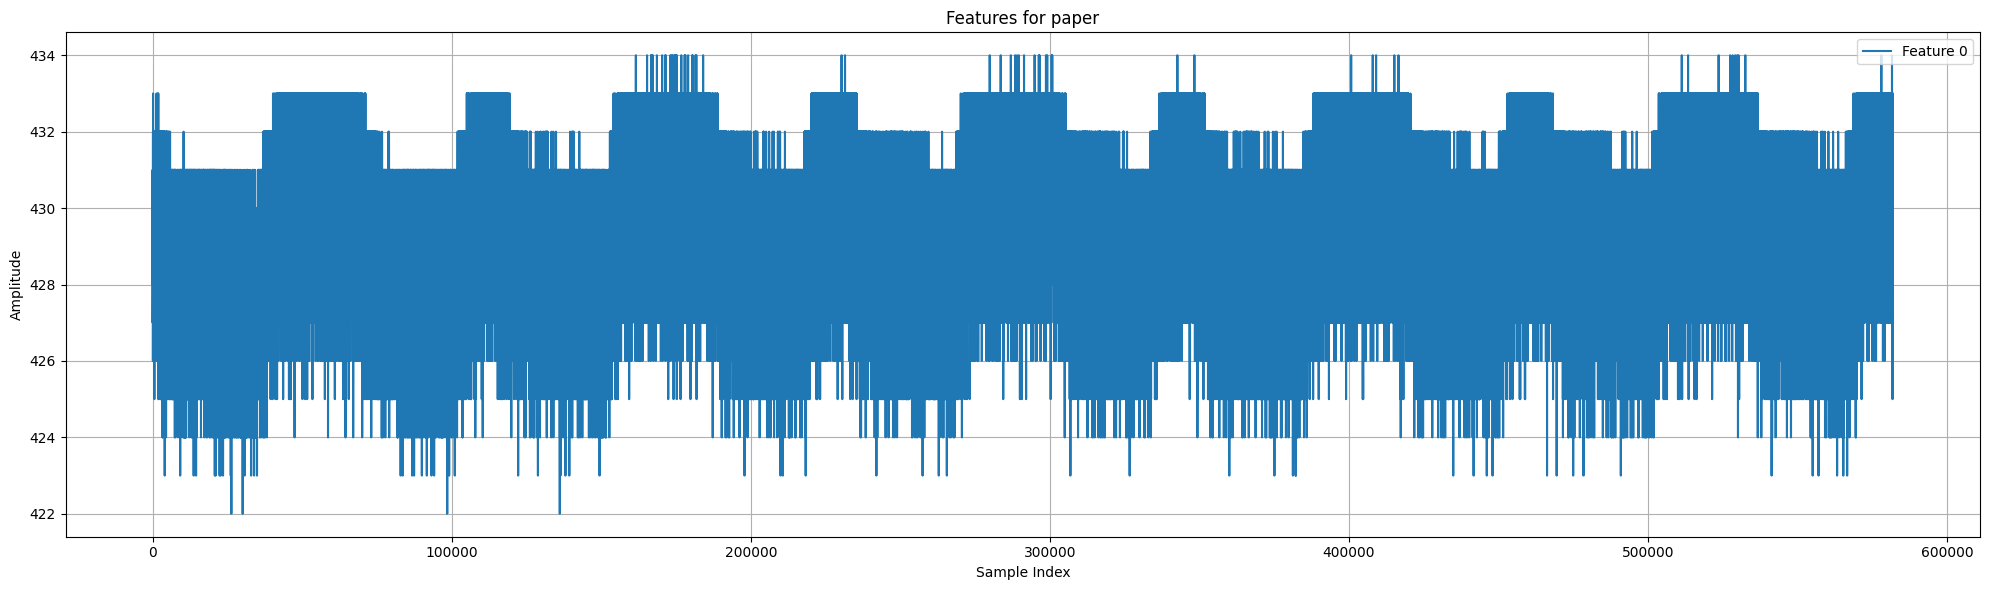

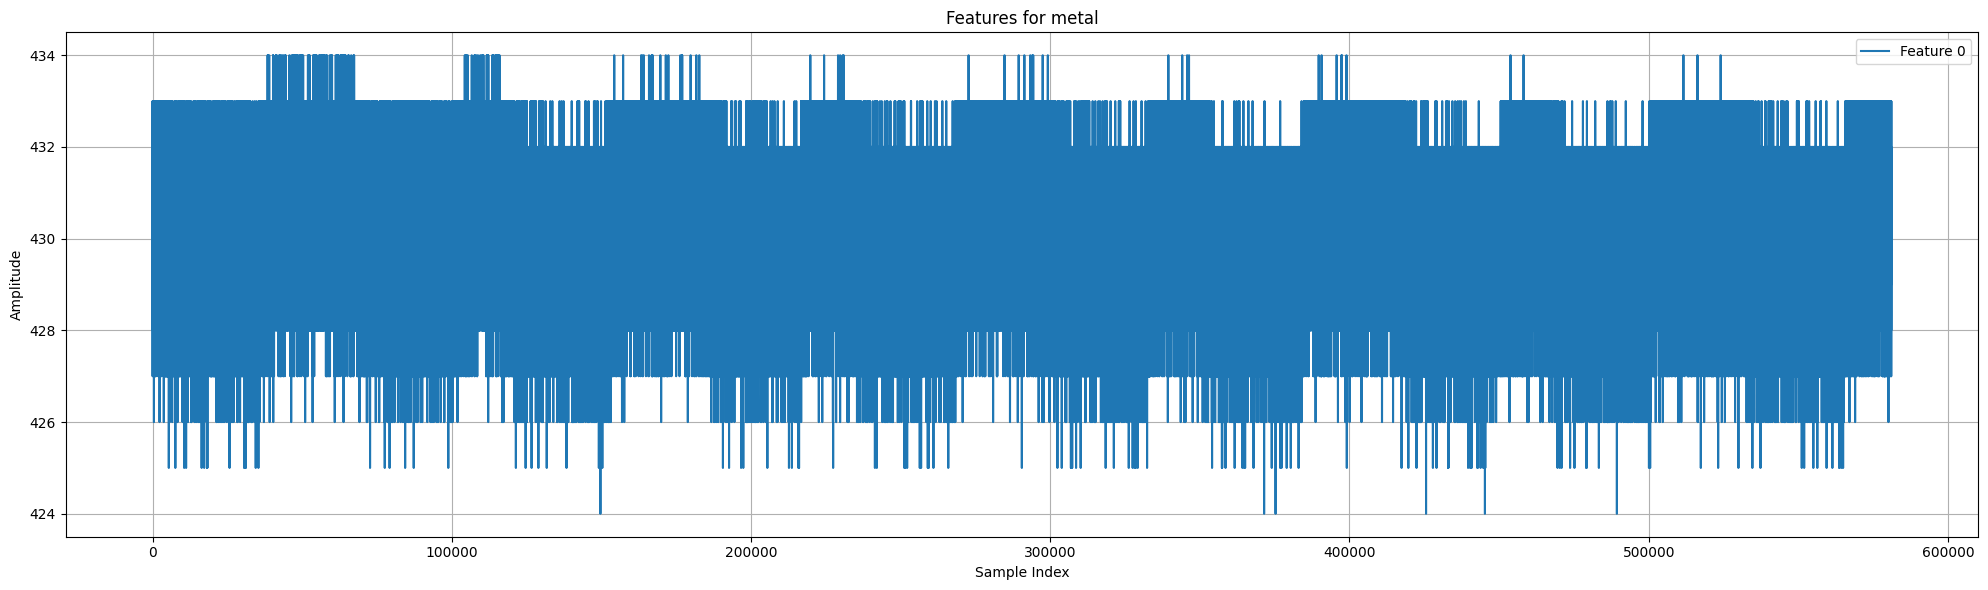

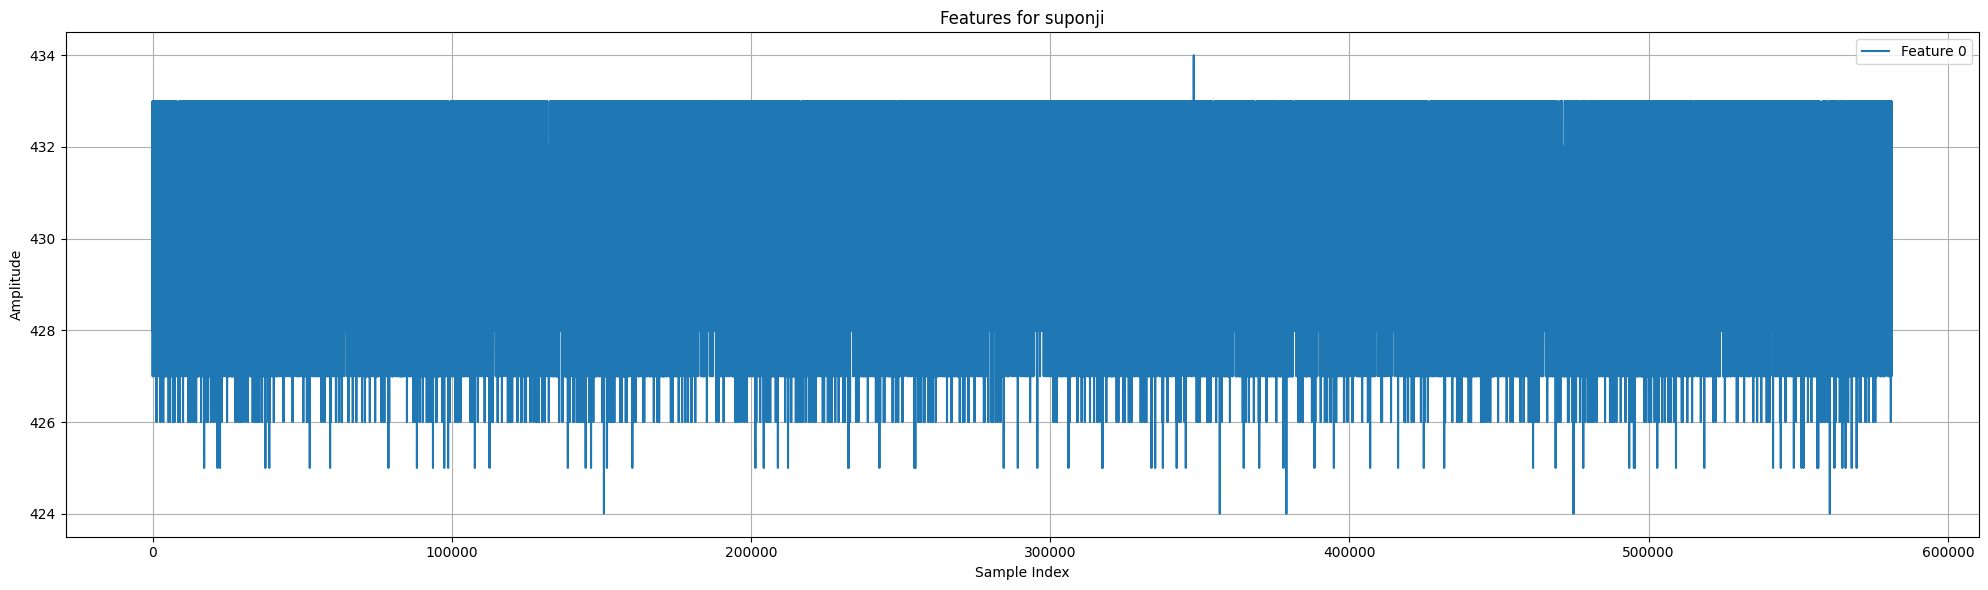

In [161]:
# 実際のフォルダとファイル名を指定
base_path = 'drive/MyDrive/素材データ_斎藤'
materials = ['cloth', 'gom', 'paper', 'metal','suponji']  # 素材のフォルダ名
times = ['1', '2', '3', '4', '5']  # 試行回数

# 破損ファイルを指定
corrupted_files = [] # 今回は無し

# 素材ごとにデータを連結
for material in materials:
    combined_data = pd.DataFrame()  # 素材ごとのデータを結合するDataFrame

    for time in times:
        file_key = f"{material}{time}"
        file_path = os.path.join(base_path, material, f'sig1_5M{file_key}_count.csv')  # ファイルパス

        # 破損ファイルをスキップ
        if f'{file_key}_1.csv' in corrupted_files:
            print(f'{file_path} は破損しているためスキップします')
            continue

        if os.path.exists(file_path):
            try:
                # データを読み込む
                data = pd.read_csv(file_path, skiprows=1, header=None)  # 最初の行をスキップ

                # ノイズ除去 (関数定義済みを仮定)
                # filtered_data = apply_lowpass_filter(data, samplerate=200)
                # filtered_data = filtered_data.reset_index(drop=True)
                filtered_data = data

                # クラスラベル（素材名）を追加
                filtered_data['class'] = material

                # 素材ごとの結合データに追加
                combined_data = pd.concat([combined_data, filtered_data], ignore_index=True)

            except Exception as e:
                print(f"エラー内容: {type(e).__name__}, {e}")
        else:
            print(f'{file_key} のデータが見つかりませんでした')

    # データを結合して描画
    if not combined_data.empty:
        plt.figure(figsize=(20, 6))

        # 数値列だけを選択
        numeric_columns = combined_data.select_dtypes(include='number').columns

        # 数値列（ここでは1列）を描画
        for col in numeric_columns:
            plt.plot(combined_data.index, combined_data[col], label=f'Feature {col}')

        # グラフの詳細設定
        plt.title(f'Features for {material}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper right')
        plt.grid(True)

        plt.tight_layout()
        plt.show()


cloth has 5820 rows after sampling.


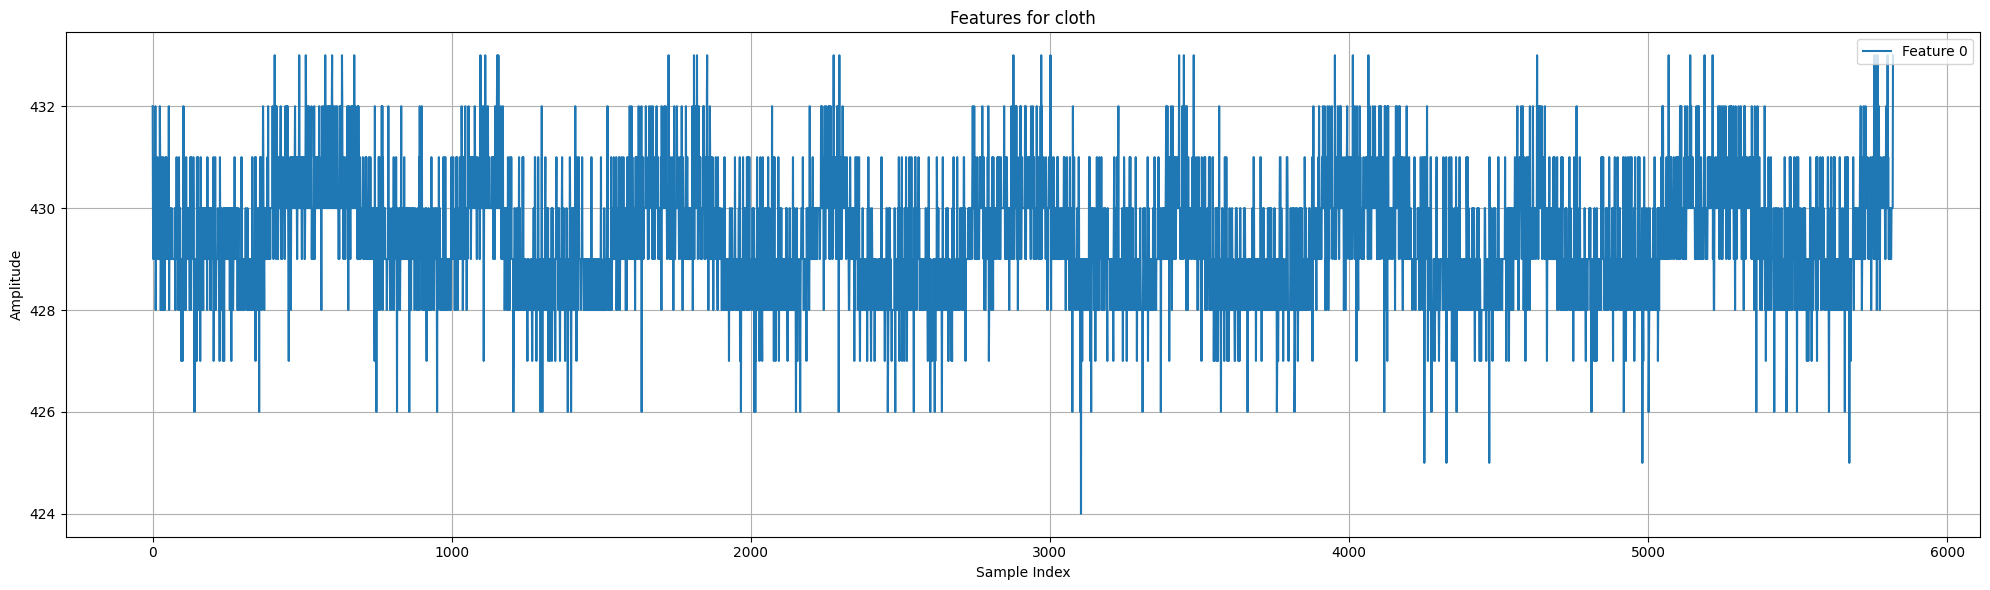

gom has 5815 rows after sampling.


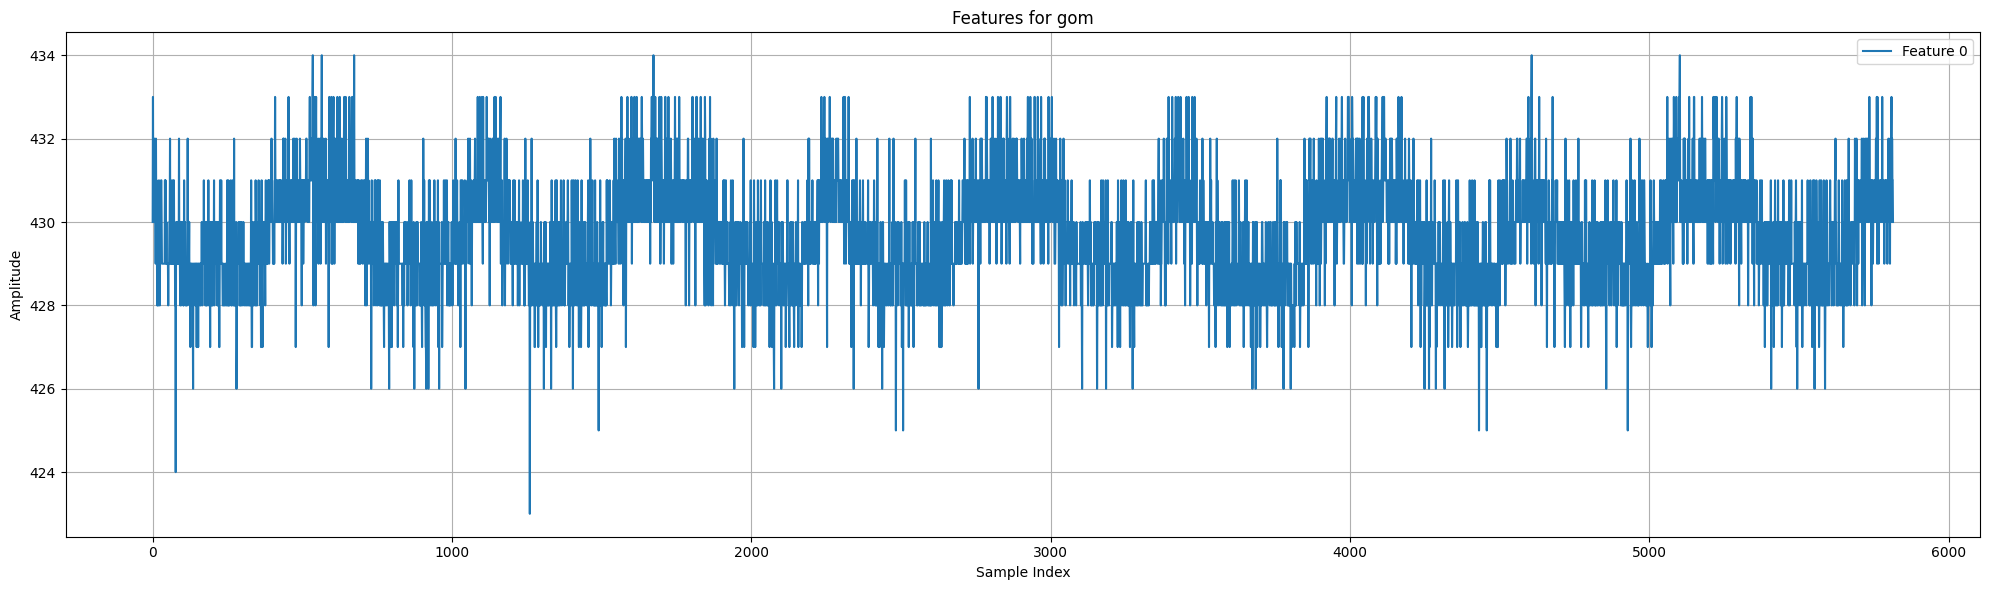

paper has 5820 rows after sampling.


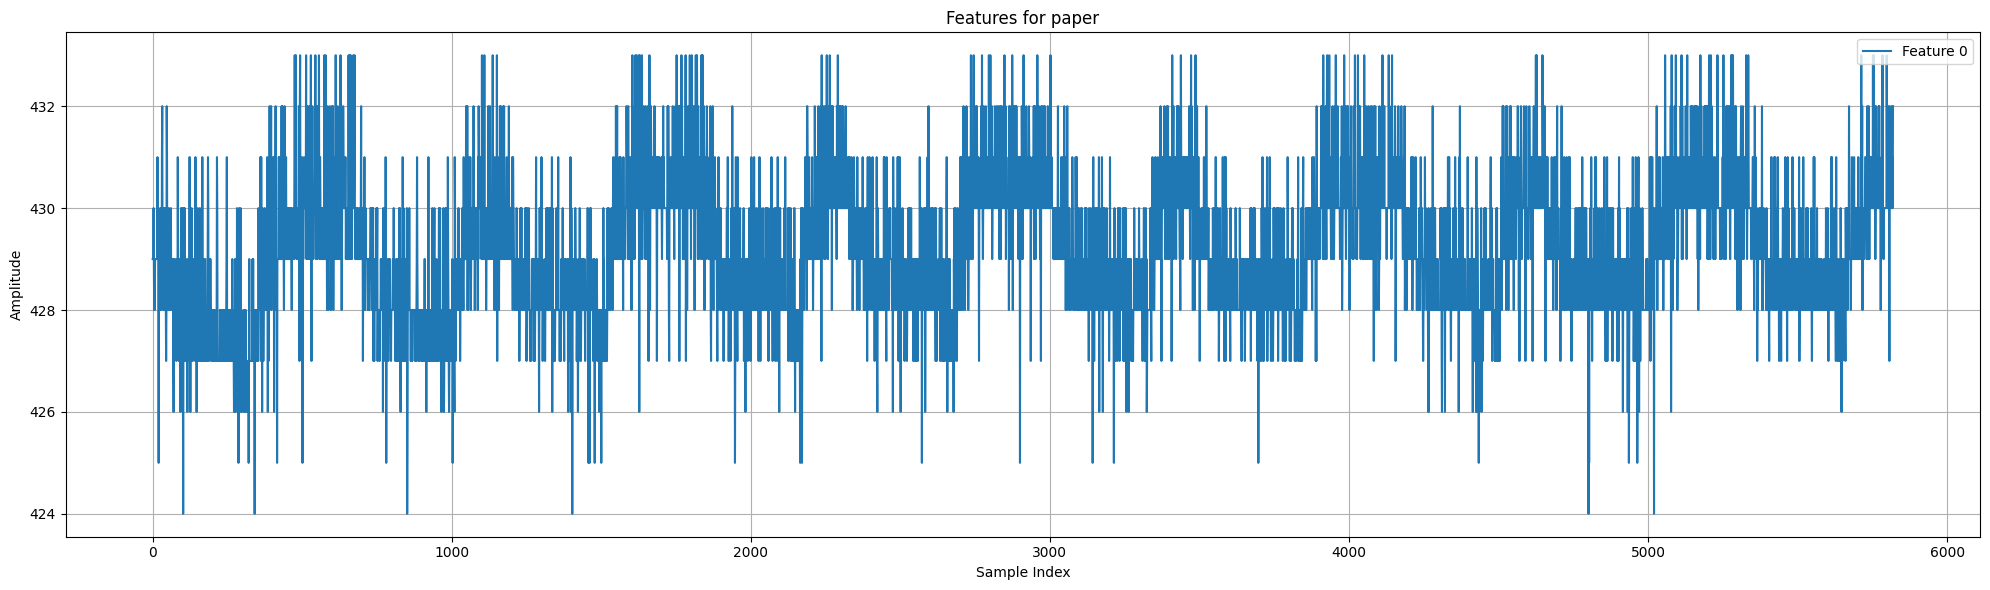

metal has 5811 rows after sampling.


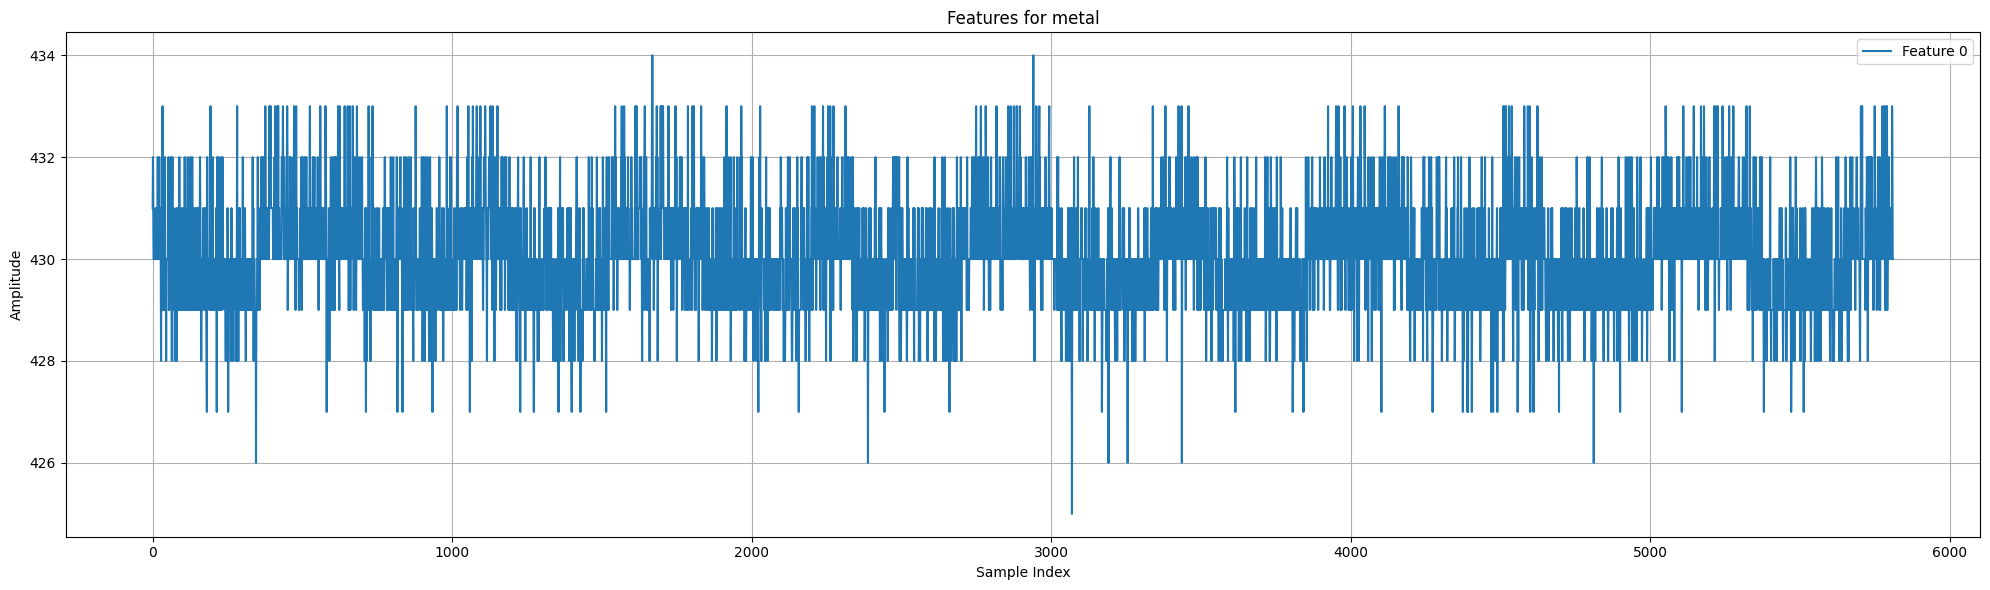

suponji has 5813 rows after sampling.


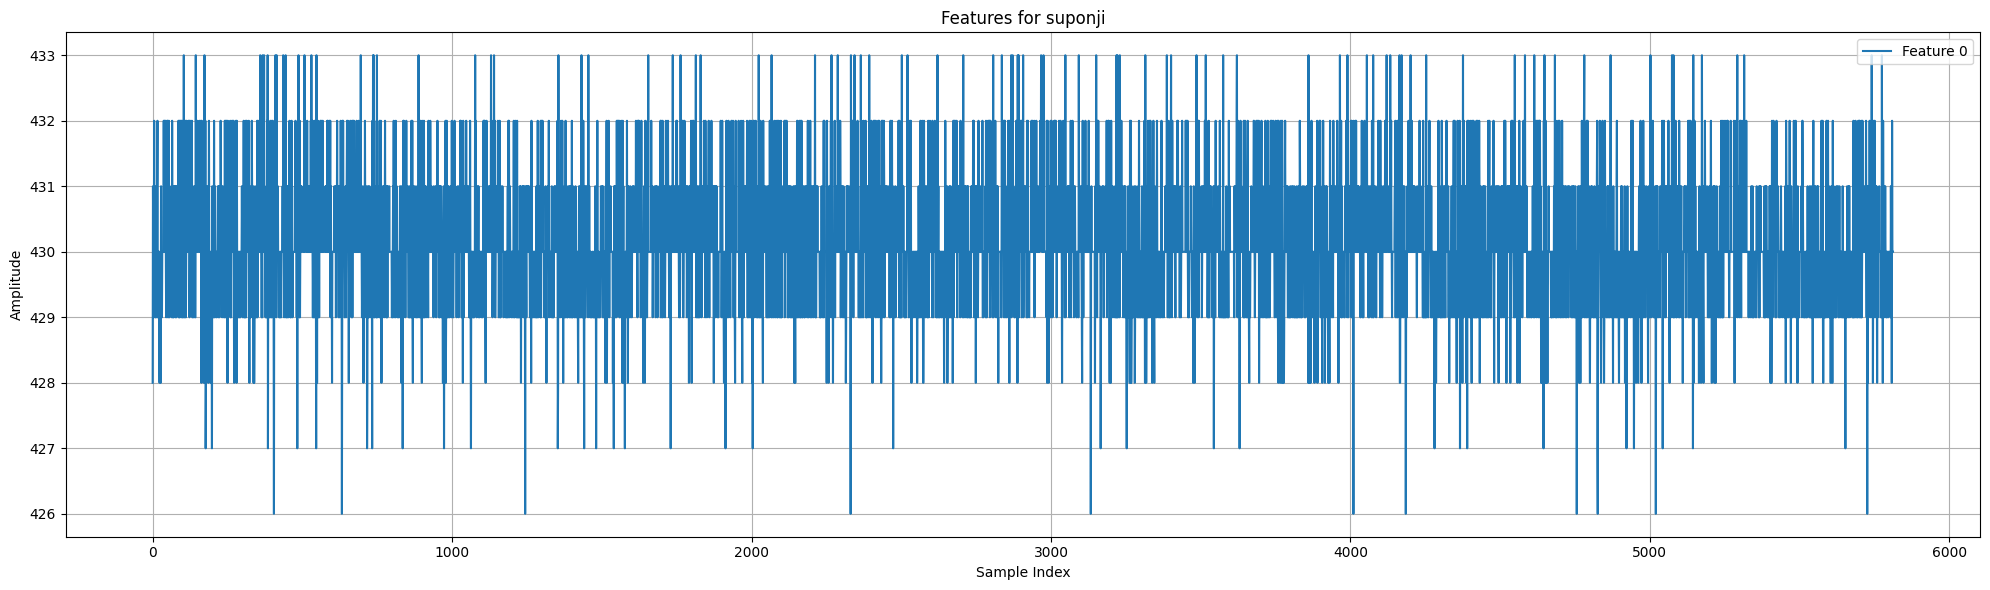

In [160]:
# 実際のフォルダとファイル名を指定
base_path = 'drive/MyDrive/素材データ_斎藤'
materials = ['cloth', 'gom', 'paper', 'metal','suponji']  # 素材のフォルダ名
times = ['1', '2', '3', '4', '5']  # 試行回数

# 破損ファイルを指定
corrupted_files = [] # 今回は無し

# 素材ごとにデータを連結
for material in materials:
    combined_data = pd.DataFrame()  # 素材ごとのデータを結合するDataFrame

    for time in times:
        file_key = f"{material}{time}"
        file_path = os.path.join(base_path, material, f'sig1_5M{file_key}_count.csv')  # ファイルパス

        # 破損ファイルをスキップ
        if f'{file_key}_1.csv' in corrupted_files:
            print(f'{file_path} は破損しているためスキップします')
            continue

        if os.path.exists(file_path):
            try:
                # データを読み込む
                data = pd.read_csv(file_path, skiprows=1, header=None)  # 最初の行をスキップ

                # ノイズ除去 (関数定義済みを仮定)
                # filtered_data = apply_lowpass_filter(data, samplerate=200)
                # filtered_data = filtered_data.reset_index(drop=True)
                filtered_data = data

                # クラスラベル（素材名）を追加
                filtered_data['class'] = material

                # 素材ごとの結合データに追加
                combined_data = pd.concat([combined_data, filtered_data], ignore_index=True)

            except Exception as e:
                print(f"エラー内容: {type(e).__name__}, {e}")
        else:
            print(f'{file_key} のデータが見つかりませんでした')
        # 元データを5個おきにサンプリング
    combined_data = combined_data.iloc[::100].reset_index(drop=True)
    print(f"{material} has {len(combined_data)} rows after sampling.")  # サンプリング後のデータ数を確認

    # データを結合して描画
    if not combined_data.empty:
        plt.figure(figsize=(20, 6))

        # 数値列だけを選択
        numeric_columns = combined_data.select_dtypes(include='number').columns

        # 数値列（ここでは1列）を描画
        for col in numeric_columns:
            plt.plot(combined_data.index, combined_data[col], label=f'Feature {col}')

        # グラフの詳細設定
        plt.title(f'Features for {material}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend(loc='upper right')
        plt.grid(True)

        plt.tight_layout()
        plt.show()


In [158]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
# カスタムDatasetクラスの定義
# クラスラベルのマッピングを定義
label_mapping = {'cloth': 0, 'gom': 1, 'paper': 2, 'metal': 3, 'suponji': 4}
class CustomDataset(Dataset):
    def __init__(self,  materials, times, base_path, corrupted_files, window_size=500, overlap=250):
        self.times = times
        self.materials = materials
        self.base_path = base_path
        self.corrupted_files = corrupted_files
        self.window_size = window_size
        self.overlap = overlap
        self.labels = [] # ラベルを格納
        self.windows_all_data = [] # 切り出し後の全データを格納
        self.windowed_data = {} # 切り出し後のデータをクラスごとに格納
        self.data = self.load_data()


    # データの読み込みとウィンドウ切り出し
    def load_data(self):
        # 素材ごとにデータを連結
        for material in materials:
            combined_data = pd.DataFrame()  # 素材ごとのデータを結合するDataFrame

            for time in times:
                file_key = f"{material}{time}"
                file_path = os.path.join(base_path, material, f'sig1_5M{file_key}_count.csv')  # ファイルパス

                # 破損ファイルをスキップ
                if f'{file_key}_1.csv' in corrupted_files:
                    print(f'{file_path} は破損しているためスキップします')
                    continue

                if os.path.exists(file_path):
                    try:
                        # データを読み込む
                        data = pd.read_csv(file_path, skiprows=1, header=None)  # 最初の行をスキップ

                        # ノイズ除去 (関数定義済みを仮定)
                        # filtered_data = apply_lowpass_filter(data, samplerate=200)
                        # filtered_data = filtered_data.reset_index(drop=True)
                        filtered_data = data

                        # クラスラベル（素材名）を追加
                        filtered_data['class'] = material

                        # 素材ごとの結合データに追加
                        combined_data = pd.concat([combined_data, filtered_data], ignore_index=True)

                    except Exception as e:
                        print(f"エラー内容: {type(e).__name__}, {e}")
                else:
                    print(f'{file_key} のデータが見つかりませんでした')

            print(f"{material} has {len(combined_data)} windows before subsampling.") # 切り出しの整合性確認用
            # 元データを5個おきにサンプリング
            combined_data = combined_data.iloc[::50].reset_index(drop=True)
            print(f"{material} has {len(combined_data)} rows after sampling.")  # サンプリング後のデータ数を確認

            # クラスごとにウィンドウデータを切り出す
            class_windows = []
            for i in range(0, len(combined_data) - self.window_size + 1, self.window_size - self.overlap):
                  window = combined_data.iloc[i:i+self.window_size] # windowで切り出し
                  class_windows.append(window) # class_windowに切り出した波形を追加
                  self.windows_all_data.append(window) # すべてのwindowデータ数を格納
                  self.labels.append(material) # ラベルを格納

            # クラスごとにデータを格納
            self.windowed_data[material] = class_windows


            # サンプリング
            print(f"{material} has {len(class_windows)} windows after subsampling.")

    # データセットの長さ
    def __len__(self):
        return len(self.windows_all_data)

    # データセットのアイテムを取得
    def __getitem__(self, idx):
        window = self.windows_all_data[idx]
        label = self.labels[idx]

        # 数値型データだけを選択
        window_numeric = window.select_dtypes(include=[np.number])  # 数値型のカラムのみを選択

        # DataFrameからnumpy配列に変換してからTensorに変換
        window_tensor = torch.tensor(window_numeric.to_numpy(), dtype=torch.float32)
        # 文字列ラベルを整数に変換
        label_tensor = torch.tensor(label_mapping[label], dtype=torch.long)
        return window_tensor, label_tensor


    # クラスごとにウィンドウを描画する関数
    def plot_windows_by_class(self, n_windows=3):
        # クラスごとにプロットを作成
        for material, class_windows in self.windowed_data.items():
            if len(class_windows) == 0:
                print(f"No windows available for class: {material}")
                continue

            plt.figure(figsize=(12, 6))  # 各クラスごとに図のサイズを設定

            # 各クラスからランダムにn個のウィンドウを選択
            selected_windows = random.sample(class_windows, min(n_windows, len(class_windows)))

            for i, window in enumerate(selected_windows):
                # x軸（時間軸）を作成
                time = np.arange(len(window))

                # 全特徴量を描画
                for j in range(window.shape[1] - 1):  # 最後の列は "class" 列なので除外
                    plt.plot(time, window.iloc[:, j], label=f'Feature {j+1}' if i == 0 else "")  # 最初のウィンドウのみ凡例表示

            # クラス名をタイトルに設定
            plt.title(f'Random {n_windows} Windows for Class: {material}')
            plt.xlabel('Time (Sample Index)')
            plt.ylabel('Amplitude')
            plt.grid(True)  # グリッドを表示
            plt.legend(loc='upper right')  # ラベルを右上に配置
            plt.tight_layout()  # レイアウトを調整
            plt.show()

cloth has 581956 windows before subsampling.
cloth has 11640 rows after sampling.
cloth has 22 windows after subsampling.
gom has 581424 windows before subsampling.
gom has 11629 rows after sampling.
gom has 22 windows after subsampling.
paper has 581945 windows before subsampling.
paper has 11639 rows after sampling.
paper has 22 windows after subsampling.
metal has 581069 windows before subsampling.
metal has 11622 rows after sampling.
metal has 22 windows after subsampling.
suponji has 581279 windows before subsampling.
suponji has 11626 rows after sampling.
suponji has 22 windows after subsampling.
Dataset size: 110


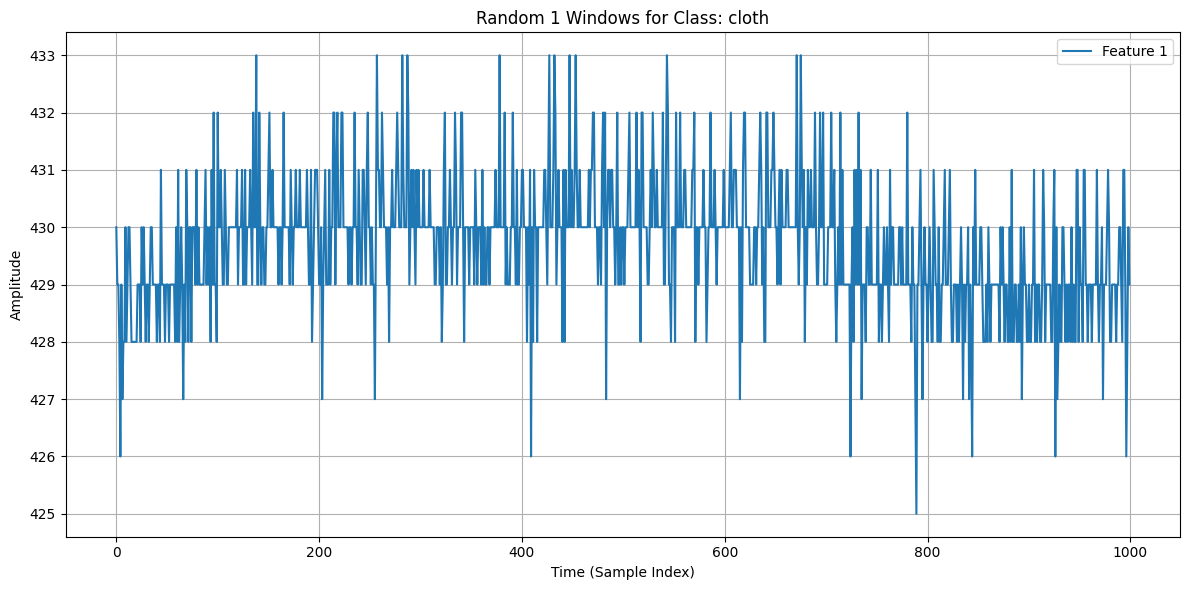

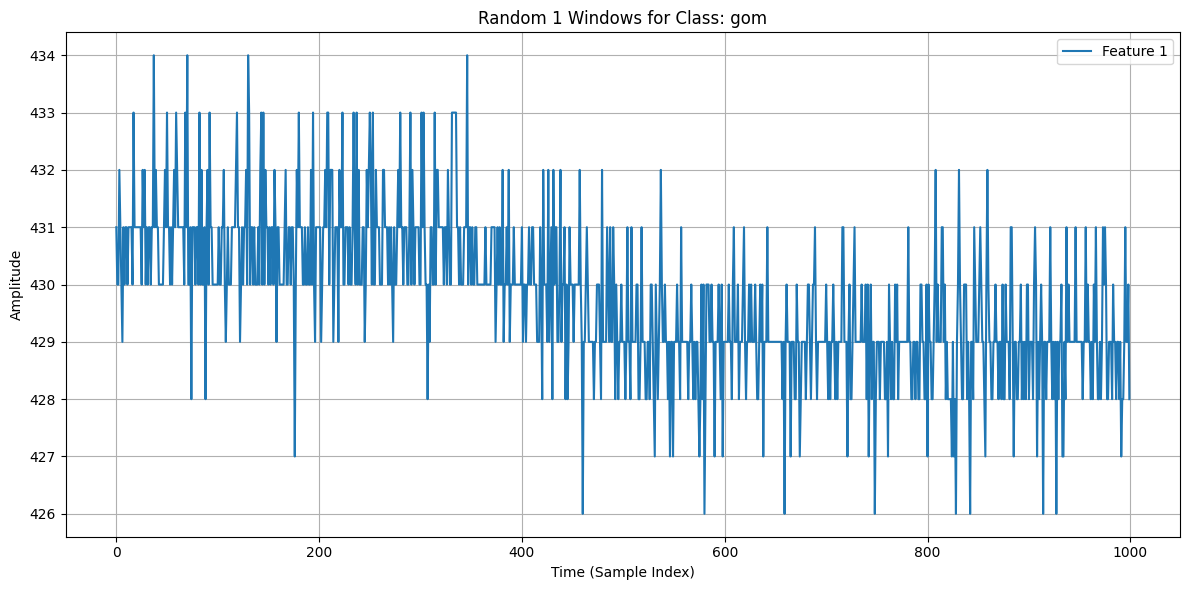

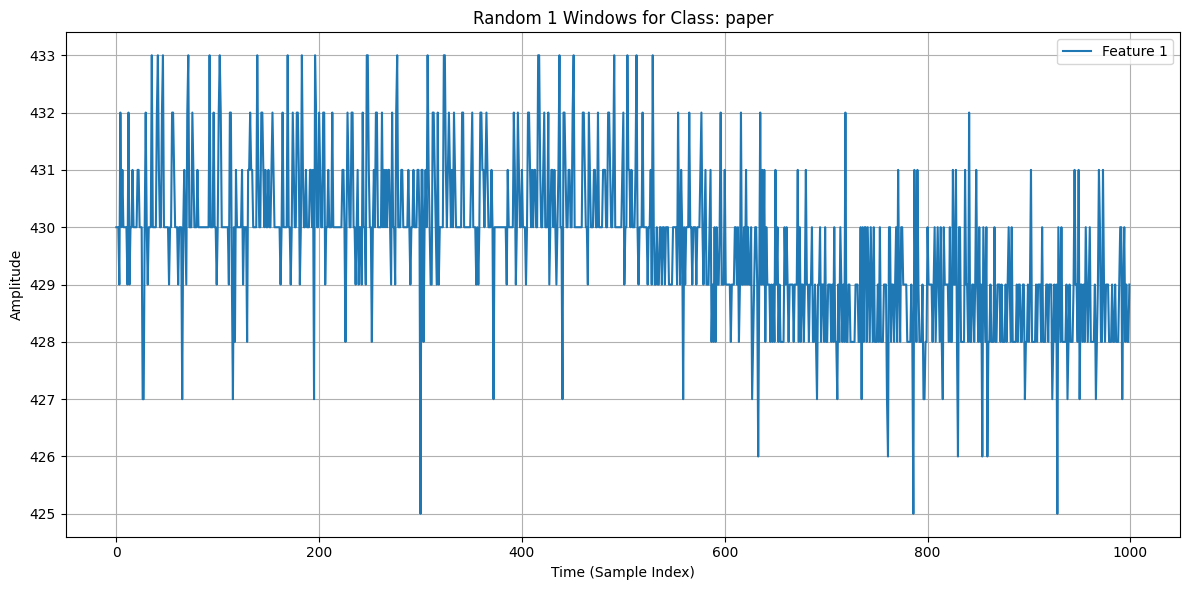

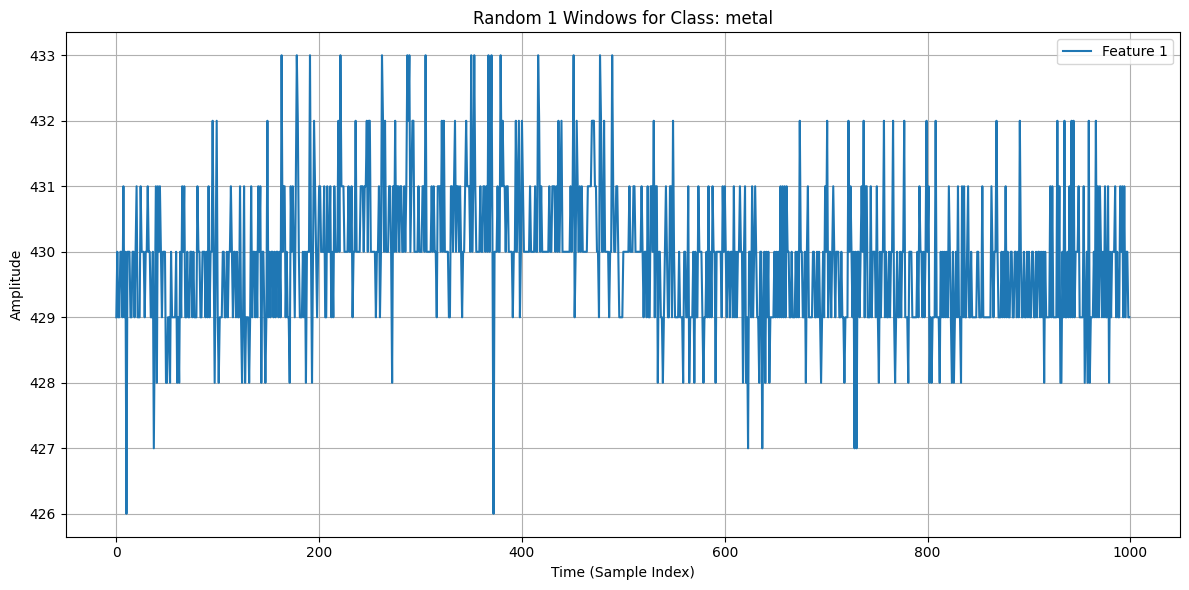

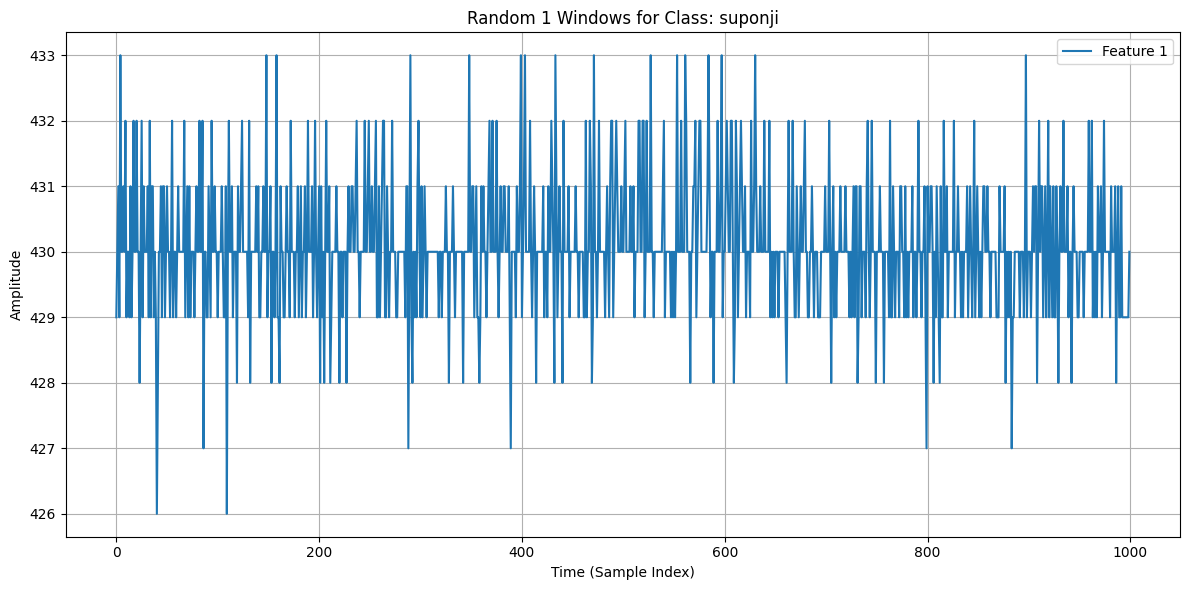

In [175]:
# カスタムデータセットをインスタンス
dataset = CustomDataset( materials, times , base_path, corrupted_files, window_size=1000, overlap=500)
# データセットの長さを確認
print(f"Dataset size: {len(dataset)}")


# 0番目のウィンドウを描画
dataset.plot_windows_by_class(n_windows=1)



In [176]:
# データセットの長さ
dataset_size = len(dataset)
from torch.utils.data import Dataset, DataLoader, random_split
# 訓練データと検証データに分割
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# データ確認（トレーニングデータ）
for batch_data, batch_labels in train_loader:
    print(f"Train Batch data shape: {batch_data.shape}")
    print(f"Train Batch labels shape: {batch_labels.shape}")
    break  # 最初のバッチだけ確認

# データ確認（検証データ）
for batch_data, batch_labels in val_loader:
    print(f"Val Batch data shape: {batch_data.shape}")
    print(f"Val Batch labels shape: {batch_labels.shape}")
    break  # 最初のバッチだけ確認

print(f"full: {len(dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")


Train Batch data shape: torch.Size([4, 1000, 1])
Train Batch labels shape: torch.Size([4])
Val Batch data shape: torch.Size([4, 1000, 1])
Val Batch labels shape: torch.Size([4])
full: 110 -> train: 88, test: 22


In [173]:
from collections import Counter

# トレーニングデータのラベル確認
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
print(f"Train labels: {train_labels[:10]}")  # 最初の10個を表示
print(f"Train label distribution: {Counter(train_labels)}")  # ラベル分布を確認

# 検証データのラベル確認
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]
print(f"Validation labels: {val_labels[:10]}")  # 最初の10個を表示
print(f"Validation label distribution: {Counter(val_labels)}")  # ラベル分布を確認


Train labels: [tensor(4), tensor(3), tensor(0), tensor(1), tensor(2), tensor(2), tensor(3), tensor(1), tensor(2), tensor(1)]
Train label distribution: Counter({tensor(4): 1, tensor(3): 1, tensor(0): 1, tensor(1): 1, tensor(2): 1, tensor(2): 1, tensor(3): 1, tensor(1): 1, tensor(2): 1, tensor(1): 1, tensor(3): 1, tensor(2): 1, tensor(1): 1, tensor(4): 1, tensor(3): 1, tensor(2): 1, tensor(3): 1, tensor(3): 1, tensor(3): 1, tensor(1): 1, tensor(4): 1, tensor(0): 1, tensor(3): 1, tensor(3): 1, tensor(2): 1, tensor(1): 1, tensor(3): 1, tensor(1): 1, tensor(3): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(4): 1, tensor(2): 1, tensor(1): 1, tensor(3): 1, tensor(3): 1, tensor(2): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(4): 1, tensor(0): 1, tensor(4): 1, tensor(0): 1, tensor(2): 1, tensor(2): 1, tensor(0): 1, tensor(2): 1, tensor(3): 1, tensor(4): 1, tensor(4): 1, tensor(0): 1, tensor(4): 1, tensor(2): 1, tensor(2): 1, 

**以下より学習モデル**

In [8]:
# 恒等写像
def identity(x):
    return x # pytorchのテンソルをそのまま処理可能


# 入力層
class Input(nn.Module):
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        super(Input, self).__init__()
        # 一様分布に従う乱数
        torch.manual_seed(seed)
        self.Win = nn.Parameter(torch.empty((N_u, N_x)).uniform_(-input_scale, input_scale))
        self.Win.requires_grad = False  # 勾配更新を不要にする

    def get_weight_matrix(self):
        # 入力行列Winを返す
        return self.Win

In [9]:
class Reservoir(nn.Module):
    def __init__(self, N_x, density, rho, activation_func,  seed):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数 (torch.nn.functional)
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        super(Reservoir, self).__init__()
        self.seed = seed
        self.N_x = N_x
        self.W = self.make_connection_pytorch(N_x, density, rho, seed)
        self.W = nn.Parameter(self.W)  # Wをnn.Parameterとしてラップ
        self.x = torch.zeros(N_x, dtype=torch.float32)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.W.requires_grad = False  # リザバーの重みは訓練しない

    @staticmethod
    def make_connection_pytorch(N_x, density, rho, seed):
        torch.manual_seed(seed)

        # ランダムな接続行列の生成
        connection = torch.bernoulli(torch.full((N_x, N_x), density))
        rec_scale = 1.0
        W = connection * (torch.rand((N_x, N_x)) * 2 * rec_scale - rec_scale)

        # Wが空でないことを確認
        if W.numel() == 0:
            raise ValueError("Weight matrix W is empty. Please check the matrix generation process.")

        # スペクトル半径を計算
        eigenvalues = torch.linalg.eigvals(W)
        if eigenvalues.numel() == 0:
            raise ValueError("Eigenvalues are empty. Check the matrix W.")

        sp_radius = torch.max(torch.abs(eigenvalues.real))

        # スペクトル半径をrhoにスケーリング
        W *= rho / sp_radius

        return W

    def get_weight_matrix_W(self):
        # 重み行列Wを返す
        return self.W




In [10]:
class Output(nn.Module):
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        super(Output, self).__init__()
        # 正規分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wout = nn.Parameter(torch.randn( N_x, N_y, dtype=torch.float32))
        self.Wout.requires_grad = True


    def get_weight_matrix_wout(self):
        # 出力行列Woutを返す
        return self.Wout


    def setweight(self, Wout_opt):
        '''
        学習済みの出力結合重み行列を設定
        param Wout_opt: 新しい重み行列 (torch.Tensor)
        '''
        if not isinstance(Wout_opt, torch.Tensor):
            raise ValueError("Wout_opt must be a torch.Tensor.")
        self.Wout = Wout_opt


In [11]:
# 未修正
class Feedback:
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wfb = (torch.rand(N_x, N_y, dtype=torch.float32) * 2 * fb_scale - fb_scale)

    def __call__(self, y):
        '''
        param y: N_y次元のベクトル (torch.Tensor)
        return: N_x次元のベクトル (torch.Tensor)
        '''
        return torch.matmul(self.Wfb, y)


In [187]:
class ESN(nn.Module):
    def __init__(self, N_u, N_y, N_x, density=0.05, input_scale=1.0e+4, rho=0.95, activation_func=torch.tanh, fb_scale=None, fb_seed=0, noise_level=None, leaking_rate=0.8, output_func=None, classification=False, average_window=None, seed = 40, sampling_rate=0.5):
        super(ESN, self).__init__()

                # デバイスの設定
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # モジュールの初期化
        self.Input = Input(N_u, N_x, input_scale).to(self.device)  # 入力層
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, seed).to(self.device) # リザバー層
        self.x_res = torch.zeros(N_x, dtype=torch.float32, device =self.device) # リザバー状態ベクトルの初期化
        self.Output = Output(N_x, N_y).to(self.device) # リードアウトを取得
        self.sampling_rate = sampling_rate


        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.activation_func = activation_func
        self.output_func = output_func if output_func is not None else lambda x: x
        self.classification = classification
        self.alpha = leaking_rate
        self.Input.requires_grad = False
        self.Reservoir.requires_grad = False

        # 出力層からのリザバーへのフィードバックの有無
        if fb_scale is None:
            self.Feedback = None
        else:
            self.Feedback = Feedback(N_y, N_x, fb_scale, fb_seed)

        # リザバーの状態更新にノイズを加えるか
        if noise_level is None:
            self.noise = None
        else:
            self.noise = torch.rand(N_x, 1) * noise_level * 2 - noise_level  # -noise_level to +noise_level

        # 分類問題の場合の設定
        if classification:
            if average_window is None:
                raise ValueError('Window for time average is not given!')
            else:
                self.window = torch.zeros((average_window, self.N_x))

        # リザバー状態の初期化
        self.reset_reservoir_state()

    def forward(self, u):
        '''
        param u: N_u次元のベクトル (torch.Tensor)
        return: N_y次元のベクトル (torch.Tensor)

        '''
        u = u.to(self.device)

        # 入力層の行列Winを取得
        Win = self.Input.get_weight_matrix().to(self.device)

        # 順伝播：入力uとWinを掛け算して、リザバー状態を更新
        x_in = torch.matmul(u, Win)

        # リザバーの行列Wを取得
        W = self.Reservoir.get_weight_matrix_W().to(self.device)


        # 順伝播：
        x_res =  (1.0 - self.alpha) * self.x_res + self.alpha * self.activation_func(torch.matmul(W, self.x_res) + x_in)
        #print(f"x_res size: {x_res.size()}")

        # リードアウトの行列Woutを取得
        Wout = self.Output.get_weight_matrix_wout().to(self.device)


        N_x = x_res.size(-1)  # 最後の次元（ノード数）を取得
        selected_indices = torch.randperm(N_x)[:int(N_x * sampling_rate)]

        # サンプルしたノードを使用する場合
        x_res_selected = x_res[:, :, selected_indices]  # ノードに対応する次元を選択
        Wout_selected = Wout[selected_indices, :]  # 対応するリードアウト行列もサンプリング
        # print(f"x_res_selected size: {x_res_selected.size()}")
        # print(f"Wout_selected size: {Wout_selected.size()}")
        y = torch.matmul(x_res, Wout)



        # print("Win requires_grad", Win.requires_grad)
        # print("W requires_grad:", W.requires_grad)
        # print("x_in requires_grad:", x_in.requires_grad)
        # print("x_res requires_grad:", x_res.requires_grad)
        # print("x_res_selected requires_grad:", x_res_selected.requires_grad)
        # print("Wout requires_grad:", Wout.requires_grad)
        # print("Wout_selected requires_grad:", Wout_selected.requires_grad)
        # print("y requires_grad:", y.requires_grad)


        #print(Wout)
        # 順伝播：
        #y = torch.matmul(x_res, Wout)
        # デバッグ用
        # print(f"u size: {u.size()}")
        # print(f"Win size: {Win.size()}")
        # print(f"x_in size: {x_in.size()}")
        # print(f"W size: {W.size()}")
        # print(f"x_res size: {x_res.size()}")
        # print(f"Wout size: {Wout.size()}")
        # print(f"y size: {y.size()}")



        # フィードバックがある場合の処理
        if self.Feedback is not None:
            self.x += self.Feedback(self.x)

        # ノイズの追加
        if self.noise is not None:
            self.x += self.noise

        # 学習前のモデル出力
        self.reset_reservoir_state() #今回のみ

        return y

    def reset_reservoir_state(self):
        '''リザバー状態ベクトルの初期化'''
        self.x = torch.zeros(self.N_x)

In [194]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# モデルのインスタンス化
N_u = 1  # 入力次元数 (12, 100 の形状から100) データによって変更
N_y = len(np.unique(dataset.labels))  # クラス数
N_x = 2000  # リザバーのサイズ
sampling_rate = 1.0  # リードアウトに接続するノード数の割合 デフォルトは0.5

model = ESN(N_u=N_u, N_y=N_y, N_x=N_x, sampling_rate=sampling_rate).to(device)  # モデルをデバイスに転送

# 最適化器と損失関数の設定
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 損失を記録するリスト
train_losses = []
val_losses = []

# 精度を記録するリスト
train_accuracies = []
val_accuracies = []

# 訓練ループ
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # 訓練モード
    train_outputs = []  # 混同行列用
    train_labels = []  # 混同行列用
    running_loss = 0.0

    # 訓練データをバッチごとに処理
    for batch_features, batch_labels in train_loader:
        # データをデバイスに転送
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()

        # 順伝播
        outputs = model(batch_features)
        #print(outputs)

        # 各チャネルに対して最も確率が高いクラスを選択
        outputs = torch.mean(outputs, dim=1)

        # 損失計算
        loss = criterion(outputs, batch_labels)

        # バックプロパゲーション
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_outputs.extend(torch.argmax(outputs, dim=1).cpu().tolist())  # デバイスからCPUに転送してリストに変換
        train_labels.extend(batch_labels.cpu().tolist())  # 同様にCPUに転送

    # エポック毎の平均損失を表示
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    train_accuracy = accuracy_score(train_labels, train_outputs)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    train_accuracies.append(train_accuracy)

    # 検証
    model.eval()  # 評価モード
    val_outputs = []
    val_labels = []
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            # データをデバイスに転送
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # 順伝播
            outputs = model(batch_features)
            outputs = torch.mean(outputs, dim=1)
            print(outputs)
            _, predicted = torch.max(outputs, 1)

            val_outputs.extend(predicted.cpu().numpy())  # CPU に転送
            val_labels.extend(batch_labels.cpu().numpy())  # 同様にCPUに転送

            loss = criterion(outputs, batch_labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    val_accuracy = accuracy_score(val_labels, val_outputs)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    val_accuracies.append(val_accuracy)


Using device: cuda
Epoch [1/50], Loss: 9.4440
Train Accuracy: 0.1818
tensor([[17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913]], device='cuda:0')
tensor([[17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913]], device='cuda:0')
tensor([[17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913]], device='cuda:0')
tensor([[17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913],
        [17.8008, 17.4604, 14.7272, 18.4078, 11.2913

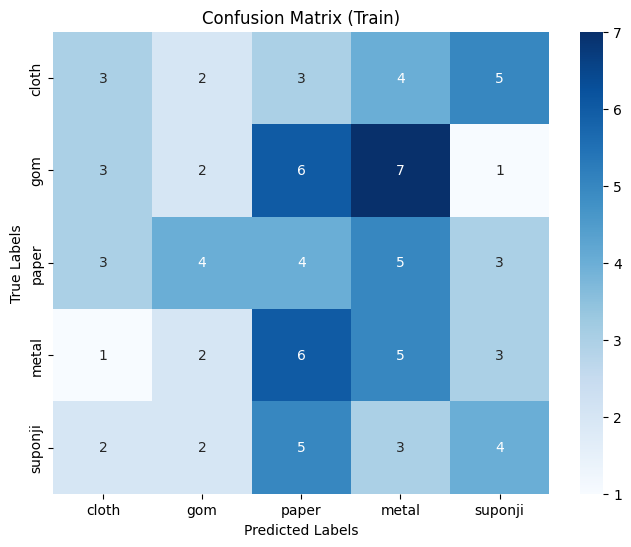

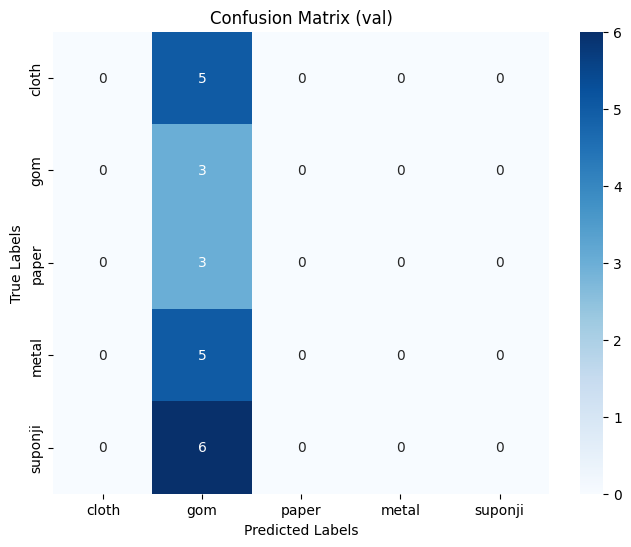

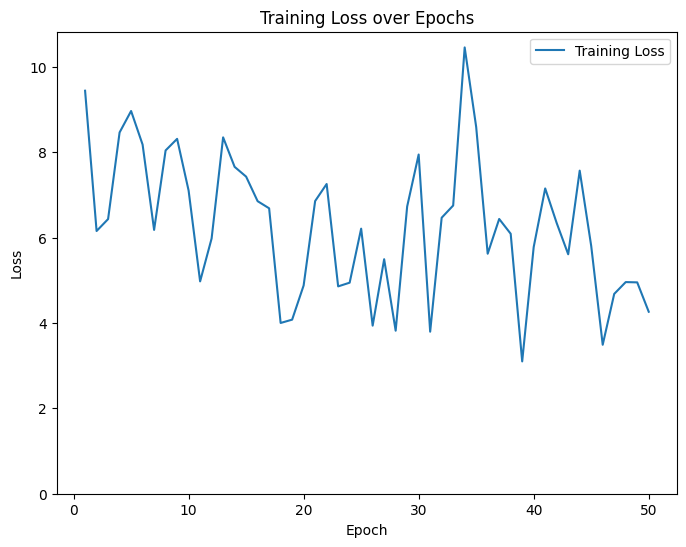

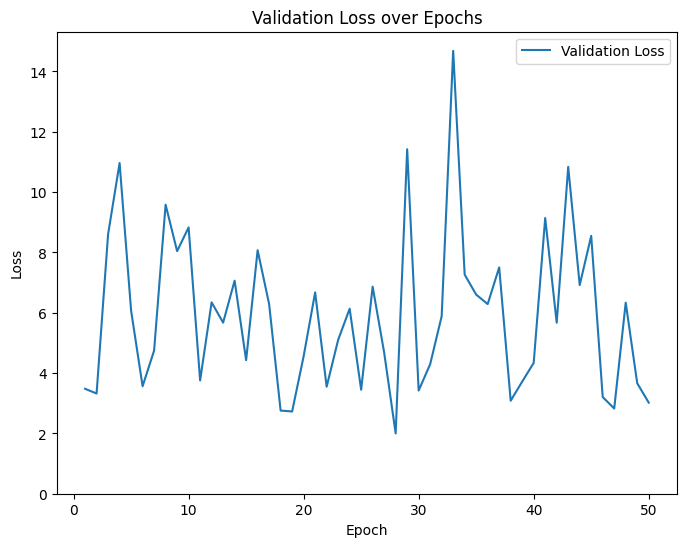

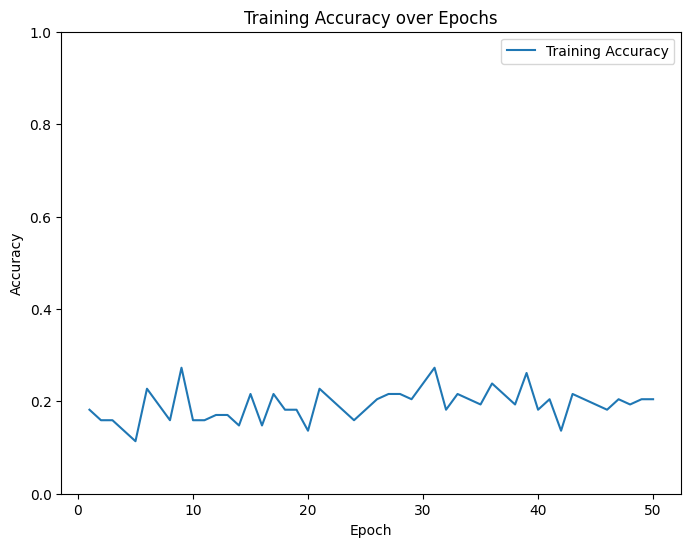

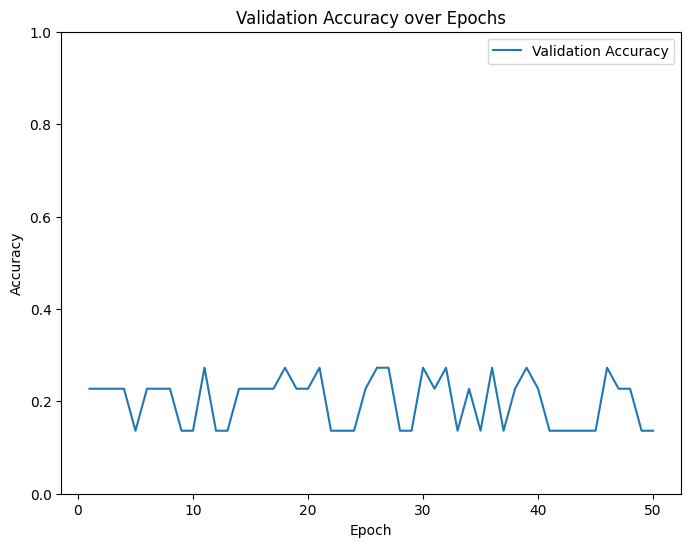

In [195]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 混同行列を計算
cm = confusion_matrix(val_labels, val_outputs)

# 訓練データに対する混同行列
cm_train = confusion_matrix(train_labels, train_outputs)

# マッピングから逆引き用リストを作成
labels = [key for key, value in sorted(label_mapping.items(), key=lambda item: item[1])]


# 訓練データの混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Train)')
plt.show()

# 検証データの混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (val)')
plt.show()

# 訓練損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.ylim(0.0)  # y軸の下限を0.0に設定
plt.legend()
plt.show()

# 検証損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.ylim(0.0)  # y軸の下限を0.0に設定
plt.legend()
plt.show()

# 訓練精度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.ylim(0, 1)  # y軸を50-100に設定
plt.legend()
plt.show()

# 検証精度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.ylim(0, 1)  # y軸を50-100に設定
plt.legend()
plt.show()
